In [1]:
import configparser
import os
import typing

import contextily
import geopandas
import numpy
import pandas
import shapely.geometry

from matplotlib import pyplot

T_DataFrame = pandas.core.frame.DataFrame

# sort of hacky, but we can't declare the axis type directly
(figure, axis) = pyplot.subplots()
T_Figure = type(figure)
T_Axis = type(axis) 
pyplot.close()

In [2]:
config = configparser.ConfigParser()
config.read("config.ini")
gdf_311 = geopandas.read_file(config["fireworks"]["processed_gpkg"])
for time_column in ["Created Date", "Closed Date"]:
    gdf_311[time_column] = pandas.to_datetime(gdf_311[time_column])

(cell copied from `01 Preprocessing.ipynb`)

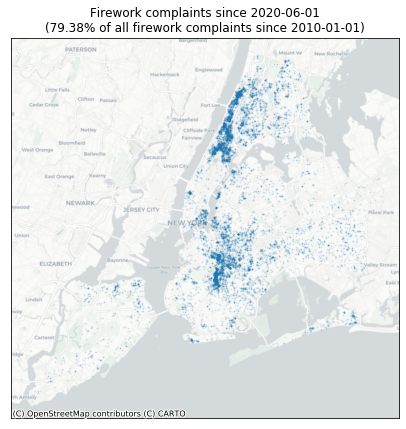

In [3]:
gdf_311_recent = gdf_311[gdf_311["Created Date"] > pandas.to_datetime("2020-06-01")]

(figure, axis) = pyplot.subplots(figsize=(7, 7))

gdf_311_recent.plot(ax=axis, markersize=1, alpha=0.1)
axis.set_xticks([])
axis.set_yticks([])
axis.set_title(
    "Firework complaints since 2020-06-01"
    "\n({:.2f}% of all firework complaints since {})".format(
        len(gdf_311_recent) / len(gdf_311) * 100,
        gdf_311["Created Date"].min().strftime("%Y-%m-%d")
    )
)
contextily.add_basemap(ax=axis, source=contextily.providers.CartoDB.Positron)
pyplot.show()

Right away, we can see very large concentrations of complaints in central Brooklyn and the Northern part of Manhattan recently. Are there any significant patterns, either temporally or spatially?

In [4]:
gdf_311_2020 = gdf_311[gdf_311["Created Date"] >= pandas.to_datetime("2020-01-01")]

# Temporal distribution

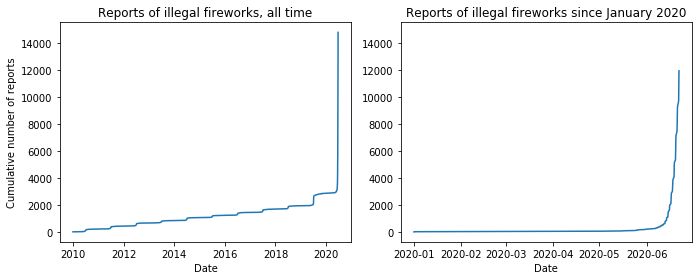

In [5]:
def plot_cumulative_reports(df: T_DataFrame,
                            axis: typing.Optional[T_Axis] = None
                            )-> (T_Figure, T_Axis):
    if axis is None:
        (figure, axis) = pyplot.subplots()
    df = df.sort_values("Created Date").reset_index(drop=True)
    axis.plot(df["Created Date"], df.index)
    axis.set_ylabel("Cumulative number of reports")
    axis.set_xlabel("Date")
    return axis

(figure, axes) = pyplot.subplots(1, 2, figsize=(10, 4))

plot_cumulative_reports(gdf_311, axes[0])
axes[0].set_title("Reports of illegal fireworks, all time")

plot_cumulative_reports(gdf_311_2020, axes[1])
axes[1].set_title("Reports of illegal fireworks since January 2020")
axes[1].set_ylabel(None)
axes[1].set_ylim(axes[0].get_ylim())

pyplot.tight_layout()

Something very strange is going on. Note the shared Y axis - the increase in May-June of 2020 is much, much larger than normal July 4th or New Years celebrations, which the small jumps in the graph on the left presumably are.

What does it look like if we zoom in a bit closer to where the firework complaints begin to increase in rate and frame it in the context of current events?

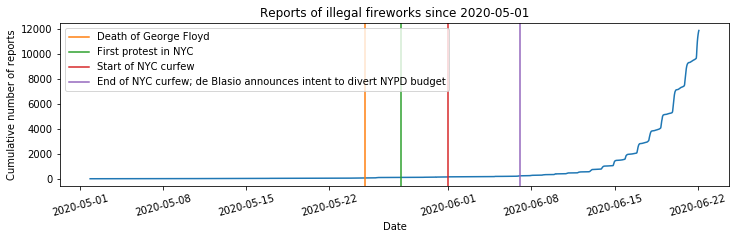

In [6]:
events = {
    # https://en.wikipedia.org/wiki/George_Floyd
    "Death of George Floyd": "2020-05-25",
    
    # https://en.wikipedia.org/wiki/George_Floyd_protests_in_New_York_City
    "First protest in NYC": "2020-05-28",
    "Start of NYC curfew": "2020-06-01",
    "End of NYC curfew; de Blasio announces intent to divert NYPD budget": "2020-06-07",
}
cutoff = "2020-05-01"

(figure, axis) = pyplot.subplots(figsize=(12, 3))
plot_cumulative_reports(
    gdf_311[gdf_311["Created Date"] >= pandas.to_datetime(cutoff)],
    axis
)
for (i, (event, date_str)) in enumerate(events.items()):
    axis.axvline(
        pandas.to_datetime(date_str),
        label=event,
        color="C{}".format(i + 1)
    )
pyplot.title("Reports of illegal fireworks since {}".format(cutoff))
pyplot.xticks(rotation=15)
pyplot.legend()
pass

From the above graph, the timing seems interesting. However, **note that correlation does not equal causation**.

It would be interesting to do some kind of regression analysis here with social media data and see if there are any relationships between the rise in firework reports and rises in certain hashtags or activity by certain groups.

Please feel free to open an issue if I missed some other major event, and I will look into addding it here.

# Analysis by hour of day

In [7]:
hourly_counts = gdf_311\
    [gdf_311["Created Date"] >= pandas.to_datetime("2020-01-01")]\
    ["Created Date"].dt.hour.value_counts()\
    .rename("count").sort_index().to_frame().rename_axis("hour")

# we will flip the polar plot by making the hour negative and rotate it 45
# degrees counterclockwise by adding 6 hours, since the polar coordinates for
# (0, y) are due right. we then rotate it back one more hour so that 12am
# is aligned at the top instead of 1am.
hourly_counts["plot_order"] = ((-numpy.arange(24) + 6 - 1) % 24)

# last row will mirror the first, to close the loop for the polar plot
hourly_counts.loc[24] = hourly_counts.loc[0]

def hour_formatter(hour: int) -> str:
    if (hour >= 11) and (hour < 23):
        ampm = "pm"
    else:
        ampm = "am"
    hour = (hour % 12) + 1
    return " ".join([str(hour), ampm])

hourly_counts["hour_str"] = [
    hour_formatter(hour)
    for hour in hourly_counts.index
]

# small transposed preview, for verification of the above algorithms
hourly_counts.T

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,1500,857,258,163,53,32,37,57,88,119,...,87,82,111,138,198,581,2544,2552,1917,1500
plot_order,5,4,3,2,1,0,23,22,21,20,...,14,13,12,11,10,9,8,7,6,5
hour_str,1 am,2 am,3 am,4 am,5 am,6 am,7 am,8 am,9 am,10 am,...,4 pm,5 pm,6 pm,7 pm,8 pm,9 pm,10 pm,11 pm,12 am,1 am


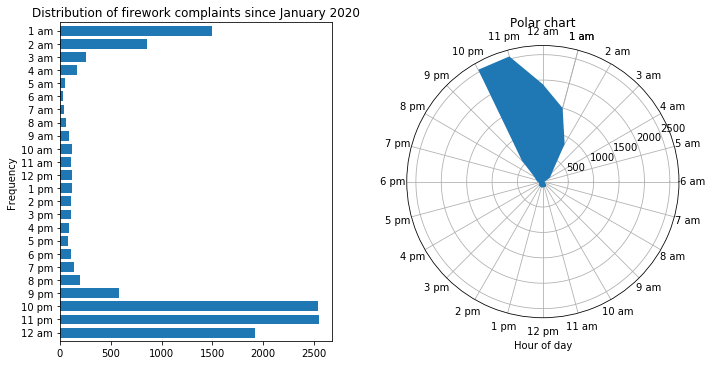

In [8]:
figure = pyplot.figure(figsize=(10, 5.2))

# bar chart
bar_axis = figure.add_subplot(1, 2, 1)
hourly_counts.sort_index(ascending=False)\
    .set_index("hour_str")["count"].iloc[1:]\
    .plot.barh(ax=bar_axis, width=0.75)
bar_axis.set_ylabel("Hour of day")
bar_axis.set_ylabel("Frequency")
bar_axis.set_title("Distribution of firework complaints since January 2020")

# polar chart
polar_axis = figure.add_subplot(1, 2, 2, projection = "polar")
polar_axis.fill_between(
    numpy.pi * 2 * hourly_counts["plot_order"] / 24,
    0, hourly_counts["count"]
)
polar_axis.set_axisbelow(True)
polar_axis.set_xlabel("Hour of day")
polar_axis.set_xticks(numpy.pi * 2 * hourly_counts["plot_order"] / 24)
polar_axis.set_xticklabels(hourly_counts["hour_str"])
polar_axis.set_title("Polar chart")

pyplot.tight_layout()
pass

From the above graph, it appears that most complaints come in between the hours of 10pm and 2am.